In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import pickle
import sys 
sys.path.insert(1,'/om/user/ehoseini/PoincareMaps')
from poincare_maps import *
from main import *
import torch 
%matplotlib inline
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
try :
    torch.set_deterministic(True)
except:
    pass
torch.set_printoptions(precision=10)

In [30]:
ROOTDIR = "/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/"
model_identifier = "NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed"
train_identifier = "epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06"
analyze_identifier = "mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5"
num_subsamples = 100
k = 100
hier_idx = 4
layers = ["layer_0_Input", "layer_1_Linear", "layer_2_Linear", "layer_3_Linear"]
layer = layers[1]
knn_identifier = f"knn_k={k}_subsamples={num_subsamples}" 
pkl_name = f"layer={layer}_hier={hier_idx}_with_data.pkl"

SAVEDIR = os.path.join(ROOTDIR, "analyze", knn_identifier, model_identifier, train_identifier)

In [31]:
data = pickle.load(open(os.path.join(SAVEDIR+"/"+pkl_name),"rb"))

In [32]:
feat=torch.tensor(data['data']).to(device)
labels=torch.tensor(np.ravel(np.stack(data['targets']))).to(device)

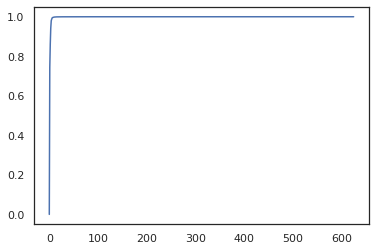

In [35]:
# reduce the dimensionality of features
low_dim_num=10
pca_type='equal_var'
u, s, v = torch.svd(feat)
# keep 85% variance explained ,
idx_85 = torch.cumsum(s ** 2, dim=0) / torch.sum(s ** 2) <= .95
cols = list(torch.where(idx_85)[0].cpu().numpy())
if pca_type == 'fixed':
    feat_pca = torch.matmul(feat, v[:, :low_dim_num])
elif pca_type == 'equal_var':
    feat_pca = torch.matmul(feat, v[:, cols])
var_explained=torch.cumsum(torch.cat((torch.tensor([0], device=feat.device,dtype=feat.dtype), s ** 2)),
                                              dim=0) / torch.sum(s ** 2)
plt.plot(var_explained.cpu())
plt.show()

In [36]:
samples=np.linspace(0,labels.shape[0]-1,10000).astype('int')

feat_subsample=feat_pca[samples,:]
label_subsample=labels[samples]

Computing laplacian...
Laplacian computed in 9.92 sec
Computing RFA...


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

RFA computed in 66.31 sec
batchsize =  512
Starting training...


loss: 2.31924: 100%|████████████████████████| 1000/1000 [09:24<00:00,  1.77it/s]

PM computed in 564.10 sec


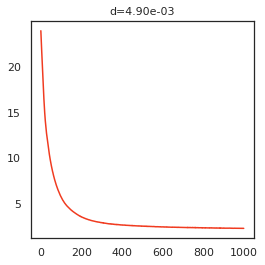

loss = 2.319e+00
time = 9.404 min


<Figure size 432x288 with 0 Axes>

In [37]:
poincare_coord, _ = compute_poincare_maps(feat_subsample.cpu(), label_subsample.cpu(),
                        f"{SAVEDIR}/poincare_maps/p_map_data_{layer}_hier_{hier_idx}",
                        mode='features', k_neighbours=15, 
                        distlocal='minkowski', sigma=1.0, gamma=2.0,
                        color_dict=None, epochs=1000,
                        batchsize=-1, lr=0.1, earlystop=0.0001, cuda=1)

In [38]:
model = PoincareMaps(poincare_coord)

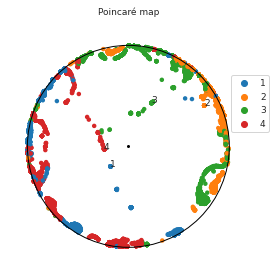

In [39]:
model.plot('ori', labels=label_subsample.cpu(), file_name=f"{SAVEDIR}/poincare_maps/p_map_plot_{layer}_hier_{hier_idx}", 
           title_name='Poincaré map',coldict=None, labels_order=None, zoom=None, bbox=(1.1, 0.8))

'/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/analyze/knn_k=100_subsamples=100/NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed/epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06/poincare_maps/layer_1_Linear_hier_3'